# EE610 - Image Processing Assignment 3

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import pywt
import cv2 as cv

**Q1a) Additive white gaussian noise(AWGN) with variable variance to any given image**

In [2]:
def add_awgn(img,var):
    img_out = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_out[i,j] = np.float32(img[i,j])+20*np.random.normal(loc=0.0,scale=var) #np.random.normal picks a random for normal distribution of given mean and variance
            #I scaled the image to range[0,255] because while calculating PSNR and SSIM image is treated just as an array unlike cv.imshow() which automatically scales array to [0,255]
    return img_out

np.random.normal() is used to add white gaussian noise to the image. The variance of the gaussian distribution is uniformly selected from [0,50] using the function np.random.rand

**Q1b) Peak signal to noise ratio(PSNR)**

In [4]:
def measure_psnr(goodImg,noisyImg):
    (m,n) = goodImg.shape
    mse = np.sum((goodImg-noisyImg)**2)/m/n
    psnr = 10*np.log10(255*255/mse)#since maximum possible value in an image is 255, peak signal value is 255
    return psnr

**Q1c) Structural similarity index measure(SSIM)**

The $SSIM$ between two images deonted by $x$ and $y$ is given by(taken from wikipedia)  
$$SSIM(x,y) = \frac{(2\mu_{x}\mu_{y}+c_1)(2\sigma_{xy}+c_2)}{(\mu^2_x+\mu^2_y+c_1)(\sigma^2_x+\sigma^2_y+c_2)}$$ 
where, $\mu_x$ - mean of image $x$  
$\mu_y$ - mean of image$y$  
$\sigma^2_x$ - variance of image $x$  
$\sigma^2_y$ - variance of image $y$  
$\sigma_{xy}$ - covariance of images $x$ and $y$  
$c_1$ = $(0.01*255)^2$  
and $c_2$ = $(0.03*255)^2$

In [5]:
def measure_ssim(goodImg,noisyImg):
    mean1 = np.mean(goodImg)
    mean2 = np.mean(noisyImg)
    var1 = np.var(goodImg)
    var2 = np.var(noisyImg)
    #from the formula cov(X,Y) = E(XY)-E(x)E(Y)
    cov = np.mean(np.float32(goodImg)*np.float32(noisyImg))-np.mean(goodImg)*np.mean(noisyImg)
    c1 = (0.01*255)**2
    c2 = (0.03*255)**2
    ssim = ((2*mean1*mean2+c1)*(2*cov+c2))/((var1+var2+c2)*(mean1**2+mean2**2+c1))
    return ssim

**Q1d) Isotropic gaussian blurring of a given variance**

In [95]:
def isotropic_gaussian(img,var):
    (rows,cols) = img.shape
    x,y = np.array(np.meshgrid(np.linspace(-1*cols/2,cols/2,cols),np.linspace(rows/2,-1*rows/2,rows)))
    #np.linspace(...) genrates an array of given length in equally dividing a given array
    #np.array(np.meshgrid(...)) generates a nD array given n 1D arrays
    dst = np.sqrt(x**2+y**2)
    gauss = np.exp(-((dst**2*var)/(2*np.min(img.shape))))
    gaussian = np.zeros((rows,cols,2))
    gaussian[:,:,0] = gauss
    gaussian[:,:,1] = gauss
    
    dft = cv.dft(np.float32(img),flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    fshift = dft_shift*gaussian
    ishift = np.fft.ifftshift(fshift)
    img_back = cv.idft(ishift)
    img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])
    img_back = (img_back*255)/np.max(img_back)
    #same as the reason for scaling awgn image
    return img_back

I applied gaussian lowpass filter in frequency domain. So I first calculated the DFT of the image and multiplied it with the generated gaussian filter array of the same size. It should be noted that since variance in frequency domain is reciprocal of the variance in space domain, I have taken the input variance to the numerator. So the user of the function gives variance having the spatial picture but the function implements the filter in frequency domain

**Testing the functions**

(<matplotlib.image.AxesImage at 0x18a824092b0>,
 Text(0.5, 1.0, 'Gaussian lowpass with var=5'))

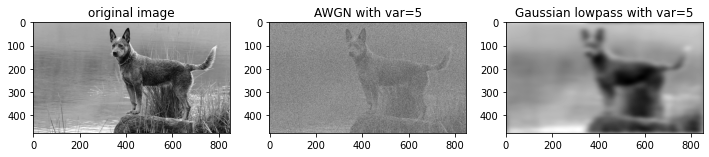

In [96]:
img1 = cv.imread('dog1.jpg',0)
img1_awgn = add_awgn(img1,5)
img1_gauss = isotropic_gaussian(img1,5)
img1_gauss = (img1_gauss*255)/np.max(img1_gauss)
plt.figure(figsize=(12,15))
plt.subplot(131),
plt.imshow(img1,cmap='gray'),plt.title('original image')
plt.subplot(132),
plt.imshow(img1_awgn,cmap='gray'),plt.title('AWGN with var=5')
plt.subplot(133),
plt.imshow(img1_gauss,cmap='gray'),plt.title('Gaussian lowpass with var=5')

In [11]:
print('PSNR of image with AWGN =',measure_psnr(img1,img1_awgn))
print('PSNR of Gausian lowpass image =',measure_psnr(img1,img1_gauss))
print('SSIM of image with AWGN =',measure_ssim(img1,img1_awgn))
print('SSIM of Gaussian lowpass image =',measure_ssim(img1,img1_gauss))
print('SSIM of img1 with itself =',measure_ssim(img1,img1))

PSNR of image with AWGN = 8.124774987467259
PSNR of Gausian lowpass image = 19.590287559640867
SSIM of image with AWGN = 0.2955522074682341
SSIM of Gaussian lowpass image = 0.8811181903848856
SSIM of img1 with itself = 1.000000104144147


We can observe in the values obtaied that both PSNR and SSIM indicate that gaussian lowpass image is more distorted than the AWGN image and this is in accordance with what we find visually. Also, we can note how SSIM of img1 with itself gives value very close to 1 as one would expect

**Q2a)Function for hard thresholding**

In [271]:
def threshold_hard(img,var):
    print(img.shape)
    threshold = np.sqrt(2*var*np.log10(3*3))
    LL,(LH,HL,HH) = pywt.dwt2(img,'haar')
    print(LL.shape,LH.shape)
    for i in range(LL.shape[0]):
        for j in range(LL.shape[1]):
            if np.abs(LH[i][j])<threshold:
                LH[i][j]=0
            if np.abs(HL[i][j])<threshold:
                HL[i][j]=0
            if np.abs(HH[i][j])<threshold:
                HH[i][j]=0
    return pywt.idwt2((LL,(LH,HL,HH,)),'haar')
#pywt.dwt(..) and pywt.idwt(..) functions are taken by Pywavelet libriary and code was inspired by Pywavelet official
#documentation "https://pywavelets.readthedocs.io/en/latest/"

**Q2b) Function for soft thresholding**

In [276]:
def threshold_soft(img,var):
    threshold = np.sqrt(2*var*np.log10(4*4))
    LL,(LH,HL,HH) = pywt.dwt2(img,'haar')
    for i in range(LL.shape[0]):
        for j in range(LL.shape[1]):
            LH[i][j]=0 if np.abs(LH[i][j])<threshold else LH[i][j]-(LH[i][j]/np.abs(LH[i][j]))*threshold
            HL[i][j]=0 if np.abs(HL[i][j])<threshold else HL[i][j]-(HL[i][j]/np.abs(HL[i][j]))*threshold
            HH[i][j]=0 if np.abs(HH[i][j])<threshold else HH[i][j]-(HH[i][j]/np.abs(HH[i][j]))*threshold
    return pywt.idwt2((LL,(LH,HL,HH)),'haar')

**Q3a)PSNR and SSIM variation by varying variance of AWGN**

C:\Users\hp\AppData\Local\Temp\ipykernel_9144\2754414119.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  psnr = 10*np.log10(255*255/mse)


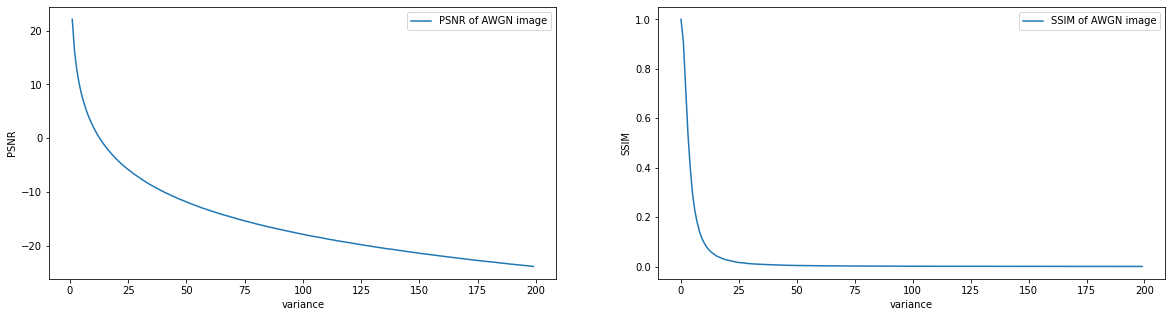

In [100]:
img1 = cv.imread('dog1.jpg',0)
var1 = np.arange(0,200,1)
var2 = np.arange(0,200,1)
psnr1 = np.zeros((200,1))
ssim1 = np.zeros((200,1))
for i in range(200):
    psnr1[i] = measure_psnr(img1,(add_awgn(img1,var1[i])))
    ssim1[i] = measure_ssim(img1,(add_awgn(img1,var1[i])))
plt.figure(figsize=(20,5))
plt.subplot(121),
plt.plot(var1,psnr1,label="PSNR of AWGN image")
plt.xlabel("variance")
plt.ylabel("PSNR")
plt.legend()
plt.subplot(122),
plt.plot(var2,ssim1,label="SSIM of AWGN image")
plt.xlabel("variance")
plt.ylabel("SSIM")
plt.legend()

**Q3b)PSNR and SSIM variation by varying variance of Gaussian lowpass filter**

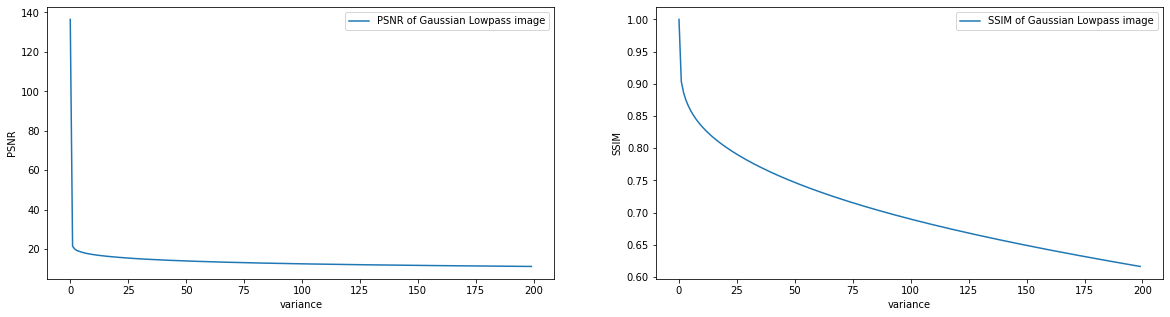

In [101]:
psnr2 = np.zeros((200,1))
ssim2 = np.zeros((200,1))
for i in range(200):
    psnr2[i] = measure_psnr(img1,isotropic_gaussian(img1,var2[i]))
    ssim2[i] = measure_ssim(img1,isotropic_gaussian(img1,var2[i]))
plt.figure(figsize=(20,5))
plt.subplot(121),
plt.plot(var2,psnr2,label="PSNR of Gaussian Lowpass image")
plt.xlabel("variance")
plt.ylabel("PSNR")
plt.legend()
plt.subplot(122),
plt.plot(var2,ssim2,label="SSIM of Gaussian Lowpass image")
plt.xlabel("variance")
plt.ylabel("SSIM")
plt.legend()

From the plots we can observe that both PSNR and SSIM decrese with increase in variance of the noise as we would expect.

**Q3c) Soft and Hard thresholding with theshold $\lambda =\sqrt{2\sigma^2\log n^2}$ where $n$ is window size which is $3$ in our case**

In [ ]:
n=20
img3 = img1[:476,:]
sd=np.arange(0,n,1)
psnr_hard = np.zeros((n,1))
ssim_hard = np.zeros((n,1))
psnr_soft = np.zeros((n,1))
ssim_soft = np.zeros((n,1))
for i in range(n):
    psnr_hard[i] = measure_psnr(img3,threshold_hard(img3,sd[i]**2))
    ssim_hard[i] = measure_ssim(img3,threshold_hard(img3,sd[i]**2))
    psnr_soft[i] = measure_psnr(img3,threshold_soft(img3,sd[i]**2))
    ssim_soft[i] = measure_ssim(img3,threshold_soft(img3,sd[i]**2))

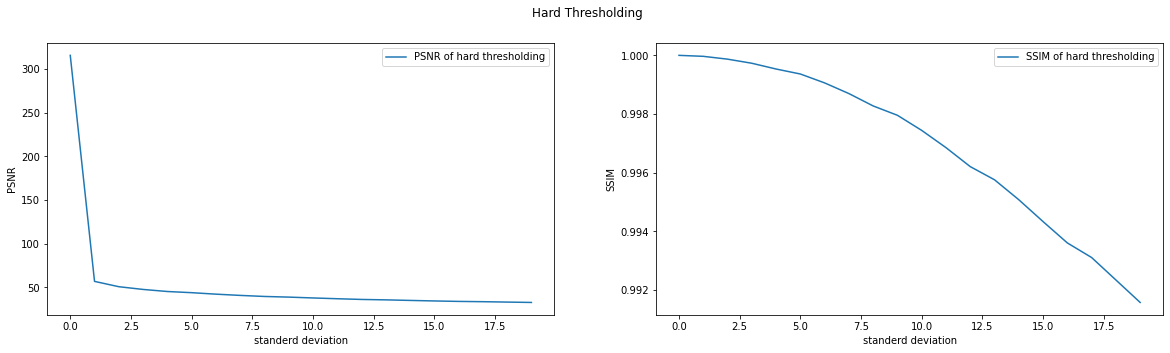

In [285]:
plt.figure(figsize=(20,5))
plt.suptitle("Hard Thresholding")
plt.subplot(121),
plt.plot(sd,psnr_hard,label="PSNR of hard thresholding")
plt.xlabel("standerd deviation")
plt.ylabel("PSNR")
plt.legend()
plt.subplot(122),
plt.plot(sd,ssim_hard,label="SSIM of hard thresholding")
plt.xlabel("standerd deviation")
plt.ylabel("SSIM")
plt.legend()

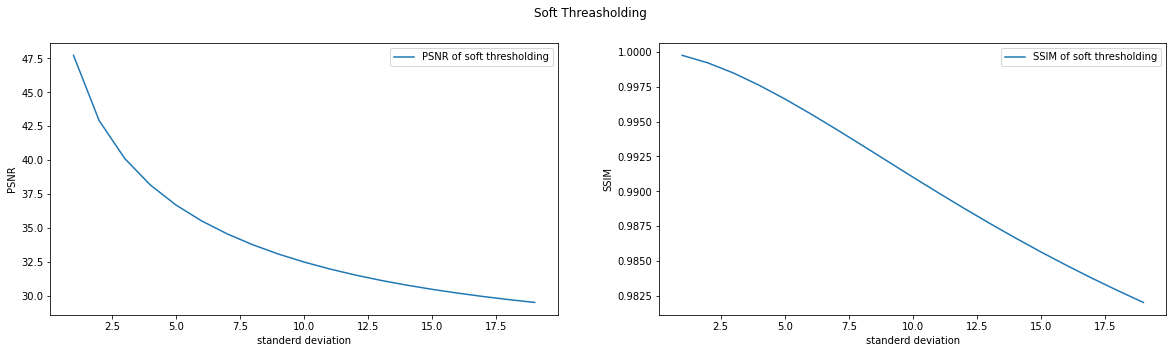

In [286]:
plt.figure(figsize=(20,5))
plt.suptitle("Soft Threasholding")
plt.subplot(121),
plt.plot(sd,psnr_soft,label="PSNR of soft thresholding")
plt.xlabel("standerd deviation")
plt.ylabel("PSNR")
plt.legend()
plt.subplot(122),
plt.plot(sd,ssim_soft,label="SSIM of soft thresholding")
plt.xlabel("standerd deviation")
plt.ylabel("SSIM")
plt.legend()

Here also PSNR and SSIM decreses with variance as one would expect. But compared to AWGN and Gaussian lowpass the decrement is low in case of wavelets

**Q3e)PSNR and SSIM variation for I in HSI and RGB channels seperately**

In [75]:
img2 = cv.imread('dog1.jpg')
(rows,cols)=img2.shape[:2]
(b,g,r) = cv.split(img2)
I = (r/3+g/3+b/3).astype(np.uint8)

In [77]:
psnr1_rgb = np.zeros((200,1))
psnr1_I = np.zeros((200,1))
ssim1_rgb = np.zeros((200,1))
ssim1_I = np.zeros((200,1))
for i in range(200):
    r_awgn = add_awgn(r,i)
    g_awgn = add_awgn(g,i)
    b_awgn = add_awgn(b,i)
#     r_gauss = isotropic_gaussian(r,var[i])
#     g_gauss = isotropic_gaussian(g,var[i])
#     b_gauss = isotropic_gaussian(b,var[i])
    mse1_rgb = 3*(np.sum((r-r_awgn)**2)+np.sum((g-g_awgn)**2)+np.sum((b-b_awgn)**2))/(rows*cols)
    psnr1_rgb[i] = 10*np.log10(255*255/mse1_rgb)
    psnr1_I[i] = measure_psnr(I,add_awgn(I,i))
    ssim1_rgb[i] = measure_ssim(r,r_awgn)
    ssim1_I[i] = measure_ssim(I,add_awgn(I,i))

C:\Users\hp\AppData\Local\Temp\ipykernel_9144\2254980981.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  psnr1_rgb[i] = 10*np.log10(255*255/mse1_rgb)
C:\Users\hp\AppData\Local\Temp\ipykernel_9144\2754414119.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  psnr = 10*np.log10(255*255/mse)


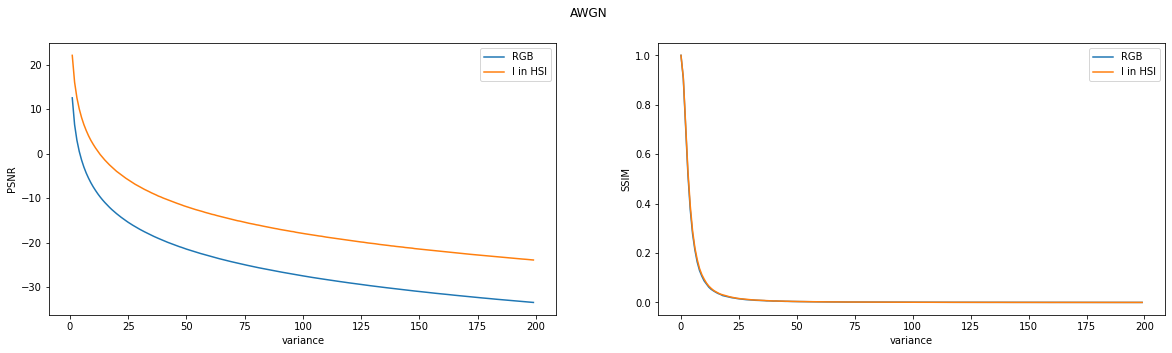

In [78]:
plt.figure(figsize=(20,5))
plt.suptitle("AWGN")
plt.subplot(121),
plt.plot(np.arange(0,200,1),psnr1_rgb,label="RGB")
plt.plot(np.arange(0,200,1),psnr1_I,label='I in HSI')
plt.xlabel("variance")
plt.ylabel("PSNR")
plt.legend()
plt.subplot(122),
plt.plot(np.arange(0,200,1),ssim1_rgb,label='RGB')
plt.plot(np.arange(0,200,1),ssim1_I,label='I in HSI')
plt.xlabel("variance")
plt.ylabel("SSIM")
plt.legend()

In [79]:
(b,g,r) = cv.split(img2)
I = (r/3+g/3+b/3).astype(np.uint8)
psnr2_rgb = np.zeros((200,1))
psnr2_I = np.zeros((200,1))
ssim2_rgb = np.zeros((200,1))
ssim2_I = np.zeros((200,1))
var = np.arange(0,20,0.1)
for i in range(200):
    r_gauss = isotropic_gaussian(r,var[i])
    g_gauss = isotropic_gaussian(g,var[i])
    b_gauss = isotropic_gaussian(b,var[i])
    mse2_rgb = 3*(np.sum((r-r_gauss)**2)+np.sum((g-g_gauss)**2)+np.sum((b-b_gauss)**2))/(rows*cols)
    psnr2_rgb[i] = 10*np.log10(255*255/mse2_rgb)
    psnr2_I[i] = measure_psnr(I,isotropic_gaussian(I,var[i]))
    ssim2_rgb[i] = (measure_ssim(r,r_gauss)+measure_ssim(g,g_gauss)+measure_ssim(b,b_gauss))/3
    ssim2_I[i] = measure_ssim(I,isotropic_gaussian(I,var[i]))

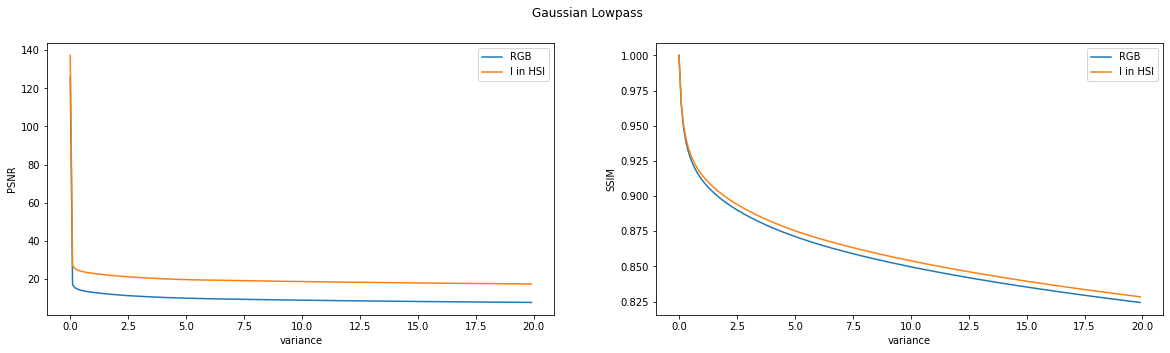

In [80]:
plt.figure(figsize=(20,5))
plt.suptitle("Gaussian Lowpass")
plt.subplot(121),
plt.plot(var,psnr2_rgb,label="RGB")
plt.plot(var,psnr2_I,label="I in HSI")
plt.xlabel("variance")
plt.ylabel("PSNR")
plt.legend()
plt.subplot(122),
plt.plot(var,ssim2_rgb,label="RGB")
plt.plot(var,ssim2_I,label="I in HSI")
plt.xlabel("variance")
plt.ylabel("SSIM")
plt.legend()

As one always PSNR and SSIM decrease with variance for both RGB and I. Of the two, RGB with each channel independently added noise has less PSNR and SSIM than I of HSI